In [1]:
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [ ]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

In [ ]:
# In[4]:


DP_DIR = 'shuffle-csvs/'
INPUT_DIR = '.'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)


# In[5]:


def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)


# ## MobileNet
# 
# MobileNets are based on a streamlined architecture that uses depthwise separable convolutions to build light weight deep neural networks.
# 
# [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)

# In[6]:


STEPS = 80
STEPS = 800
EPOCHS = 1
EPOCHS = 5 


size = 64
batchsize = 680

augment = True 

# In[7]:


model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
# print(model.summary())


# ## Training with Image Generator

# In[8]:


from svhn_noncolor_policies import good_policies
from augmentation_transforms import *

my_policies = good_policies()

cnt = 0

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

import pickle

In [88]:
def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    global cnt 

    k =  np.random.permutation(ks)[0]
    filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
    chunk = 0
    for df in pd.read_csv(filename, chunksize=batchsize):
        df['drawing'] = df['drawing'].apply(ast.literal_eval)
        x = np.zeros((len(df), size, size, 1))
        
        for i, raw_strokes in enumerate(df.drawing.values):
            x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                     time_color=time_color)
        x = preprocess_input(x).astype(np.float32)
    
        policies = [
            [('Equalize',1.0,1),('Rotate',1.0,3)],
            [('Contrast',0.3,3),('Rotate',0.8,4)],
            [('ShearX',1.0,9),('TranslateY',1.0,3)]
            ]



        for i in range(x.shape[0]):
            if i >= len(policies):
                raise Exception("Max Policies")
            else:

                epoch_policy = policies[i]

                img = np.dstack((x[i],x[i],x[i]))
                

                final_img = apply_policy(epoch_policy, img)

                sing_img = final_img[:,:,0]
                sing_img = np.reshape(sing_img,(64,64,1))
    #                         transformed_x.append(sing_img)

                print (epoch_policy)


                #print (img)
                img = np.abs(img)
                final_img = np.abs(final_img)

                fig, ax = plt.subplots(1, 2, figsize=(12, 7))
                ax[0].imshow(img)
                ax[1].imshow(final_img)
                ax[0].set_xticks([], [])
                ax[1].set_xticks([], [])
                ax[0].set_yticks([], [])
                ax[1].set_yticks([], [])
                ax[0].set_title("Before")
                ax[1].set_title("After")


                fig.suptitle("Example of a %s operation followed by a %s operation" % (epoch_policy[0][0],
                                                                                       epoch_policy[1][0]))
                


                
                
def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x


# In[9]:

[('Equalize', 1.0, 1), ('Rotate', 1.0, 3)]
[('Contrast', 0.3, 3), ('Rotate', 0.8, 4)]
[('ShearX', 1.0, 9), ('TranslateY', 1.0, 3)]


Exception: Max Policies

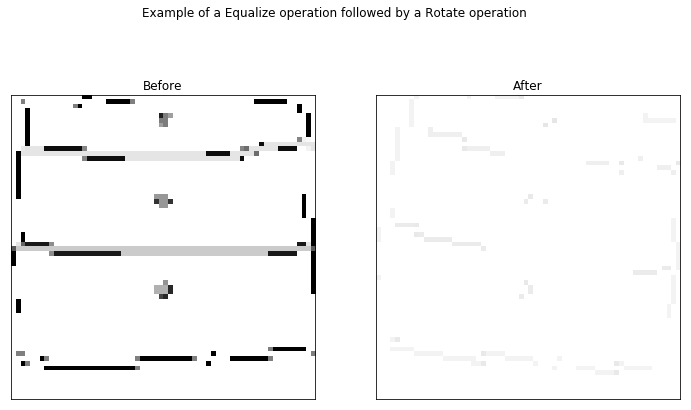

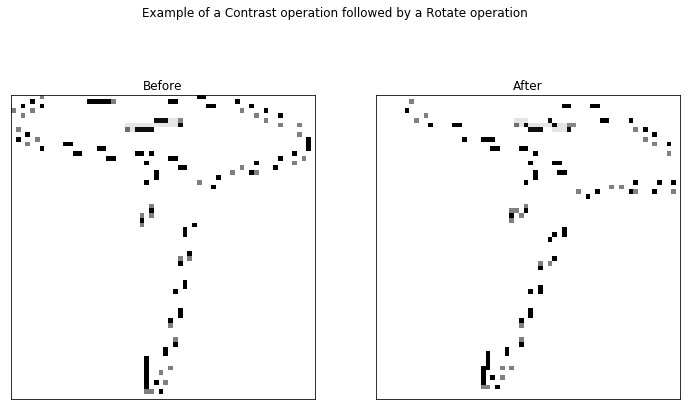

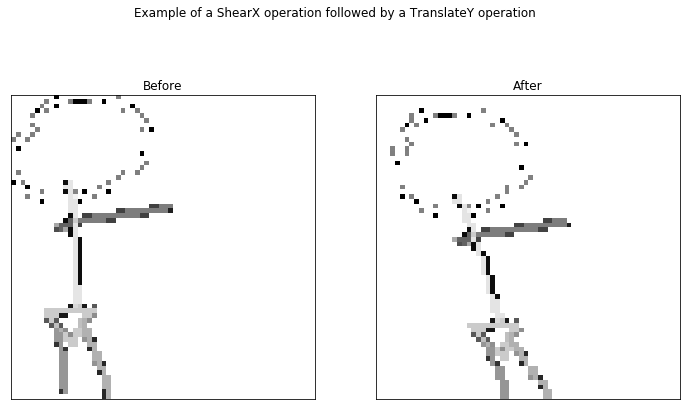

In [89]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))


# In[11]: